In [1]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import os
from torchvision import datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from math import floor
from PIL import Image
import random

In [2]:
use_google_colab = False

if use_google_colab==True:
    from google.colab import drive
    drive.mount('/content/drive')
    path_to_project = '/content/drive/MyDrive/School/1. University/Year 4/Semester 2/APS360 - Applied Fundamentals of Deep Learning/Project/'
else:
    # When using on local machine. Folder 'split_data' must be in the same dir as this file.
    path_to_project=""
    
print(path_to_project)

In [3]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

mps


In [4]:
def count_images_and_percentage_with_partition(root):
    partitions = ['train', 'val', 'test']
    classes = ['Glass', 'Metal', 'Paper', 'Plastic']
    total_images = 0
    partition_totals = {}
    counts = {}

    # Count the images in each partition and class
    for partition in partitions:
        partition_counts = {}
        partition_total = 0
        for class_name in classes:
            class_path = os.path.join(root, 'split_data', partition, class_name)
            image_files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
            count = len(image_files)
            partition_counts[class_name] = count
            partition_total += count
        counts[partition] = partition_counts
        partition_totals[partition] = partition_total
        total_images += partition_total

    # Print counts and percentages
    for partition, partition_counts in counts.items():
        print(f"'{partition}' partition: {partition_totals[partition]} images, {(partition_totals[partition] / total_images) * 100:.2f}% of total")
        for class_name, count in partition_counts.items():
            percentage = (count / partition_totals[partition]) * 100
            print(f" - {class_name}: {count} images, {percentage:.2f}% of partition")
        print()

    print(f"Total images across all partitions: {total_images}")

In [5]:
count_images_and_percentage_with_partition(path_to_project)

'train' partition: 2654 images, 69.97% of total
 - Glass: 649 images, 24.45% of partition
 - Metal: 683 images, 25.73% of partition
 - Paper: 658 images, 24.79% of partition
 - Plastic: 664 images, 25.02% of partition

'val' partition: 586 images, 15.45% of total
 - Glass: 143 images, 24.40% of partition
 - Metal: 151 images, 25.77% of partition
 - Paper: 145 images, 24.74% of partition
 - Plastic: 147 images, 25.09% of partition

'test' partition: 553 images, 14.58% of total
 - Glass: 136 images, 24.59% of partition
 - Metal: 142 images, 25.68% of partition
 - Paper: 137 images, 24.77% of partition
 - Plastic: 138 images, 24.95% of partition

Total images across all partitions: 3793


In [6]:
# Modified from Lab 3
def get_trash_data_loader(batch_size):
    """
    Returns data loaders for the training, validation, and test datasets for the trash classification project.

    Args:
        batch_size: The number of samples per batch to load.
        img_dimension: The size to resize the incoming images to. Define based on what the CNN uses (eg LargeNet256 uses 256x256).

    Returns:
        train_loader: DataLoader for the training set
        val_loader: DataLoader for the validation set
        test_loader: DataLoader for the test set
    """
    # Transforms
    transform = transforms.Compose([
        transforms.Resize((256, 256)),  # Resize to 256x256 might need to make smaller
        transforms.RandomHorizontalFlip(p=0.5),  # Random horizontal flip 50% chance
        transforms.RandomRotation(45),  # Random rotation by 45 degrees
        transforms.ToTensor(),  # Convert images to tensor
    ])

    # Paths to the folders. Each class needs to have its own folder. Eg split_data/train/Glass
    train_dataset = datasets.ImageFolder(f'{path_to_project}split_data/train', transform=transform)
    val_dataset = datasets.ImageFolder(f'{path_to_project}split_data/val', transform=transform)
    test_dataset = datasets.ImageFolder(f'{path_to_project}split_data/test', transform=transform)

    # Create data loaders
    num_workers = 2
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    
    return train_loader, val_loader, test_loader

In [7]:
class LargeNet256(nn.Module):
    def __init__(self):
        super(LargeNet256, self).__init__()

        # From v2
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=5, kernel_size=5, stride=2, padding=1)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(in_channels=5, out_channels=10, kernel_size=3, stride=1, padding=0) 
        
        self.fc1 = nn.Linear(in_features=10 * 30 * 30, out_features=32)
        
        self.fc2 = nn.Linear(in_features=32, out_features=4)

    def forward(self, x):
        # From v2
        x = self.pool(F.relu(self.conv1(x))) #convolution, relu activation, max pooling
        x = self.pool(F.relu(self.conv2(x))) #convolution, relu activation, max pooling
        x = x.view(-1, 10 * 30 * 30)
        x = F.relu(self.fc1(x)) #linear, relu activation
        x = self.fc2(x) #linear

        return x

In [8]:
# 128x128 images
class LargeNet128(nn.Module):
    def __init__(self):
        super(LargeNet128, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=5, kernel_size=5, stride=2, padding=1)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(in_channels=5, out_channels=10, kernel_size=3, stride=1, padding=0)
        
        # Adjusted for the smaller feature map size
        self.fc1 = nn.Linear(in_features=10 * 14 * 14, out_features=32)
        
        self.fc2 = nn.Linear(in_features=32, out_features=4)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 14 * 14) 
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

In [9]:
def plot_training_curve(config, train_losses, val_losses, train_accs, val_accs):
    """Plot training and validation losses and accuracies."""
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [10]:
def train(model, train_loader, valid_loader, config):
    """ Training loop. You should update this."""
    torch.manual_seed(42)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])

    best_valid_loss = float('inf')
    best_valid_acc = 0

    train_losses, valid_losses, train_accs, valid_accs = [], [], [], []

    for epoch in range(config['num_epochs']):
        model.train()  # Set model to training mode
        total_train_loss, total_train_correct = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train_correct += (predicted == labels).sum().item()

        # Calculate average training loss for the epoch
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Calculate training accuracy
        train_accuracy = total_train_correct / (len(train_loader.dataset))
        train_accs.append(train_accuracy)

        # Set model to evaluation mode
        model.eval()
        total_valid_loss, total_valid_correct = 0, 0

        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                total_valid_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_valid_correct += (predicted == labels).sum().item()

        avg_valid_loss = total_valid_loss / len(valid_loader)
        valid_accuracy = total_valid_correct / (len(valid_loader.dataset))
        valid_losses.append(avg_valid_loss)
        valid_accs.append(valid_accuracy)

        # Update best validation loss and accuracy
        if avg_valid_loss < best_valid_loss:
            best_valid_loss = avg_valid_loss
            best_valid_acc = valid_accuracy

        print(f"Epoch {epoch+1}/{config['num_epochs']}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_valid_loss:.4f}, Train Acc: {train_accuracy:.4f}, Validation Acc: {valid_accuracy:.4f}")

    # Training curve plot
    plot_training_curve(config, train_losses, valid_losses, train_accs, valid_accs)

    return best_valid_loss, best_valid_acc

Getting data loaders for current config...
Time to get data loaders: 0.02739799999999981
Epoch 1/30, Train Loss: 1.3889, Validation Loss: 1.3884, Train Acc: 0.2445, Validation Acc: 0.2440
Epoch 2/30, Train Loss: 1.3878, Validation Loss: 1.3881, Train Acc: 0.2622, Validation Acc: 0.2440
Epoch 3/30, Train Loss: 1.3871, Validation Loss: 1.3858, Train Acc: 0.2393, Validation Acc: 0.2577
Epoch 4/30, Train Loss: 1.3860, Validation Loss: 1.3856, Train Acc: 0.2581, Validation Acc: 0.2577
Epoch 5/30, Train Loss: 1.3856, Validation Loss: 1.3847, Train Acc: 0.2460, Validation Acc: 0.2884
Epoch 6/30, Train Loss: 1.3849, Validation Loss: 1.3844, Train Acc: 0.2570, Validation Acc: 0.2577
Epoch 7/30, Train Loss: 1.3838, Validation Loss: 1.3839, Train Acc: 0.2570, Validation Acc: 0.2935
Epoch 8/30, Train Loss: 1.3824, Validation Loss: 1.3807, Train Acc: 0.2615, Validation Acc: 0.2628
Epoch 9/30, Train Loss: 1.3787, Validation Loss: 1.3782, Train Acc: 0.2800, Validation Acc: 0.2509
Epoch 10/30, Train L

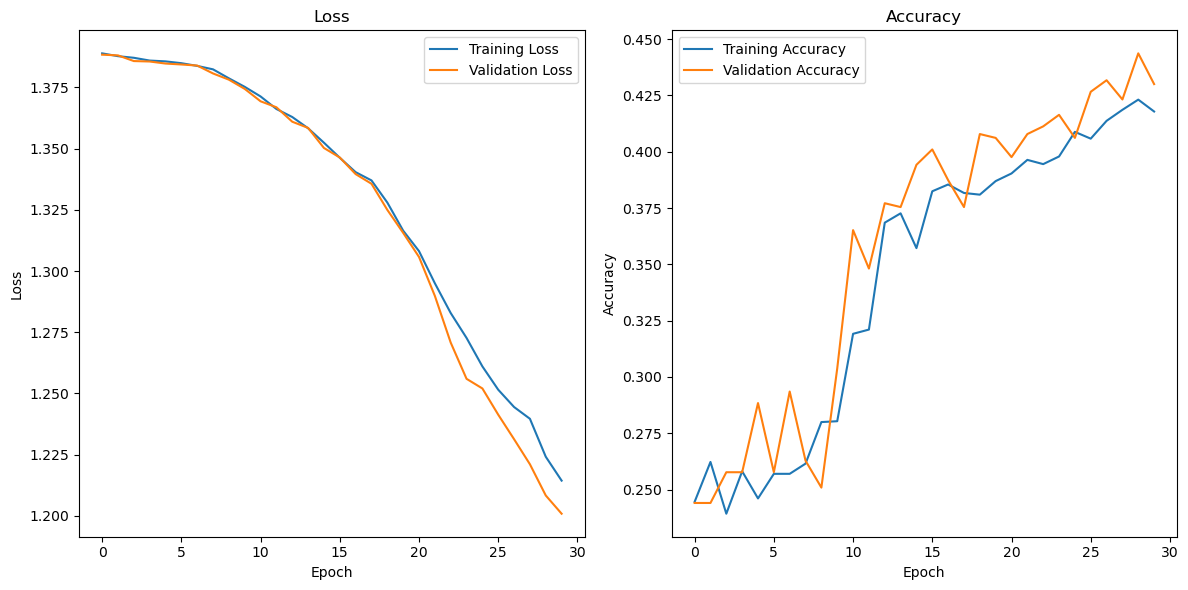

Model saved to model_LargeNet128_lr=0.0001_epochs=30_batch=128.pth
Time elapsed: 10.025517
Getting data loaders for current config...
Time to get data loaders: 0.6386789999999998
Epoch 1/30, Train Loss: 1.3855, Validation Loss: 1.3852, Train Acc: 0.2604, Validation Acc: 0.2918
Epoch 2/30, Train Loss: 1.3804, Validation Loss: 1.3764, Train Acc: 0.2886, Validation Acc: 0.2645
Epoch 3/30, Train Loss: 1.3673, Validation Loss: 1.3683, Train Acc: 0.2849, Validation Acc: 0.3242
Epoch 4/30, Train Loss: 1.3421, Validation Loss: 1.3349, Train Acc: 0.3515, Validation Acc: 0.3464
Epoch 5/30, Train Loss: 1.3091, Validation Loss: 1.3026, Train Acc: 0.3862, Validation Acc: 0.3754
Epoch 6/30, Train Loss: 1.2840, Validation Loss: 1.2795, Train Acc: 0.3960, Validation Acc: 0.4147
Epoch 7/30, Train Loss: 1.2624, Validation Loss: 1.2639, Train Acc: 0.4103, Validation Acc: 0.4096
Epoch 8/30, Train Loss: 1.2474, Validation Loss: 1.2548, Train Acc: 0.4088, Validation Acc: 0.4369
Epoch 9/30, Train Loss: 1.230

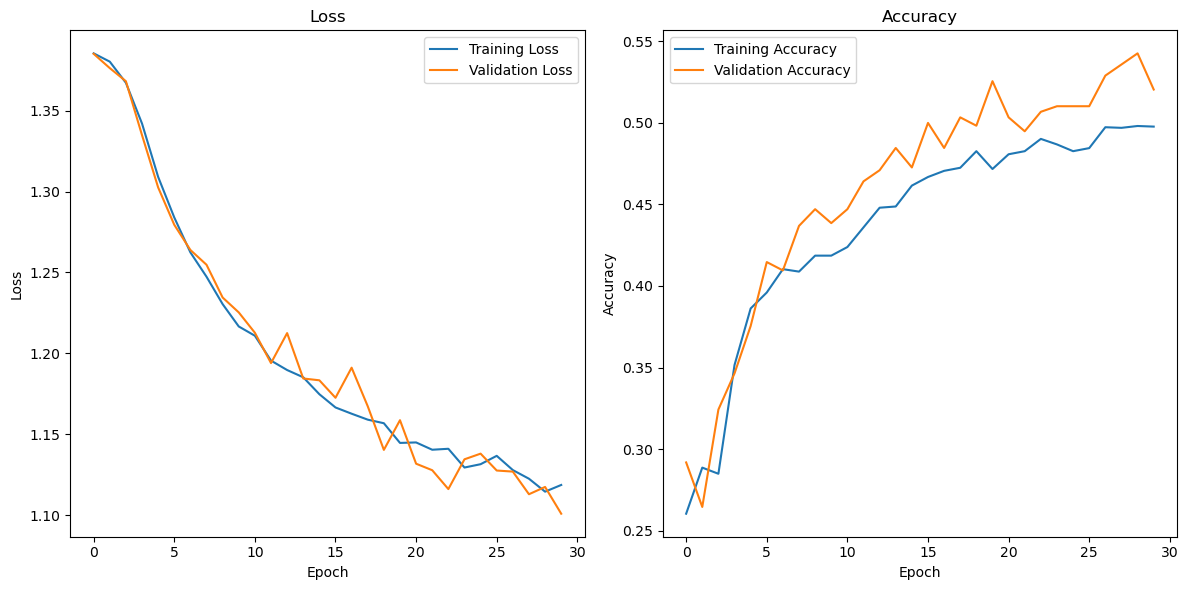

Model saved to model_LargeNet128_lr=0.0001_epochs=30_batch=64.pth
Time elapsed: 14.197439000000003
Getting data loaders for current config...
Time to get data loaders: 0.05216400000000476
Epoch 1/30, Train Loss: 1.3860, Validation Loss: 1.3850, Train Acc: 0.2656, Validation Acc: 0.2662
Epoch 2/30, Train Loss: 1.3852, Validation Loss: 1.3856, Train Acc: 0.2660, Validation Acc: 0.2662
Epoch 3/30, Train Loss: 1.3845, Validation Loss: 1.3837, Train Acc: 0.2566, Validation Acc: 0.2577
Epoch 4/30, Train Loss: 1.3838, Validation Loss: 1.3842, Train Acc: 0.2619, Validation Acc: 0.2594


In [ ]:
import time

hyperparameter_configs = [
    # {'learning_rate': 1e-3, 'num_epochs': 20, 'batch_size': 128},
    {'learning_rate': 1e-4, 'num_epochs': 30, 'batch_size': 128},
    {'learning_rate': 1e-4, 'num_epochs': 30, 'batch_size': 64},
    {'learning_rate': 1e-5, 'num_epochs': 30, 'batch_size': 64},
]

performance_tracking = []

for config in hyperparameter_configs:
    start = time.process_time()
    
    model = LargeNet256().to(device)

    print("Getting data loaders for current config...")
    train_loader, val_loader, test_loader = get_trash_data_loader(batch_size=config["batch_size"])
    print(f"Time to get data loaders: {time.process_time() - start}")
           
    best_valid_loss, best_valid_acc = train(model, train_loader, val_loader, config)

    # Track the performance for each config
    performance_tracking.append({
        'config': config,
        'best_valid_acc': best_valid_acc,
        'best_valid_loss': best_valid_loss
    })

    # Save the model after training
    model_save_path = f"{path_to_project}model_LargeNet128_lr={config['learning_rate']}_epochs={config['num_epochs']}_batch={config['batch_size']}.pth"
    torch.save(model.state_dict(), model_save_path)
    print(f"Model saved to {model_save_path}")

    print(f"Time elapsed: {time.process_time() - start}")

# Determine best performing model
best_performance = sorted(performance_tracking, key=lambda x: x['best_valid_loss'])[0]
print("Best performing model configuration:", best_performance['config'])
print("With Validation Loss:", best_performance['best_valid_loss'], "and Validation Accuracy:", best_performance['best_valid_acc'])